In [1]:
import uproot
import matplotlib.pyplot as plt
import awkward as ak
import numpy as np
import math
import ROOT as root
from array import array
from numba import jit #sorta optional (TODO - Implement toggling for numba optimization)
from collections import defaultdict
import sys
import ctypes
from numba import njit, types
from numba.typed import Dict, List

Welcome to JupyROOT 6.26/16


In [2]:
file_python = uproot.open("/sdf/home/k/ktwall/detsim_2500.root")

In [3]:
merged_tree = file_python["MergedTree"]
unmerged_tree = file_python["UnmergedTree"]
neutrino_tree = file_python["NeutrinoVertexTree"]

unmerged_times = unmerged_tree['DetSimHitT'].array()
spillnos_nvtx = neutrino_tree["NeutrinoSpill"].array()
spillnos_merged = merged_tree["MergedSpillNumber"].array()
times_merged = merged_tree["MergedDetSimHitT"].array()

In [4]:
#lets try and do a common task for this framework - loading in all the merged hits for a given neutrino interaction. 
merged_tree = file_python["MergedTree"]
merged_tree.keys()

['MergedNeutrinoNumber',
 'MergedHitNumber',
 'MergedSpillNumber',
 'MergedTrackid',
 'MergedFileNumber',
 'MergedTrueHitX',
 'MergedTrueHitY',
 'MergedTrueHitZ',
 'MergedTrueHitT',
 'MergedTrueHitDx',
 'MergedTruePrimDep',
 'MergedDetSimHitX',
 'MergedDetSimHitY',
 'MergedDetSimHitZ',
 'MergedDetSimHitT',
 'MergedDetSimHitPE',
 'MergedDetSimHitBarNo',
 'MergedDetSimHitLayerNo',
 'MergedDetSimHitBarOrient',
 'constituent_neutrino_numbers',
 'constituent_hit_numbers',
 'constituent_hit_trackids',
 'constituent_hitTs',
 'constituent_hitPEs']

In [5]:
def unpack_hits(merged_tree):
    #lets create a large array of pieces of hit information.
    nns = merged_tree['MergedNeutrinoNumber'].array()
    hns = merged_tree['MergedHitNumber'].array()
    trackids = merged_tree['MergedTrackid'].array()
    spill_nos = merged_tree['MergedSpillNumber'].array()
    detsimx = merged_tree['MergedDetSimHitX'].array()
    detsimy = merged_tree['MergedDetSimHitY'].array()
    detsimz = merged_tree['MergedDetSimHitZ'].array()
    detsimt = merged_tree['MergedDetSimHitT'].array()
    detsimPE = merged_tree['MergedDetSimHitPE'].array()
    array = np.column_stack([nns, hns, trackids, detsimx, detsimz, detsimt, detsimPE, spill_nos])
    return(array)

In [6]:
combined_array = unpack_hits(merged_tree)
combined_array 

<Array [[0, 347, 3, -519, ..., -1.79, 222, 0], ...] type='91354 * 8 * float64'>

In [7]:
event_0 = combined_array[combined_array[:,0] == 25]
event_0

<Array [[25, 147, 0, -979, ..., 513, 68.5, 0], ...] type='35 * 8 * float64'>

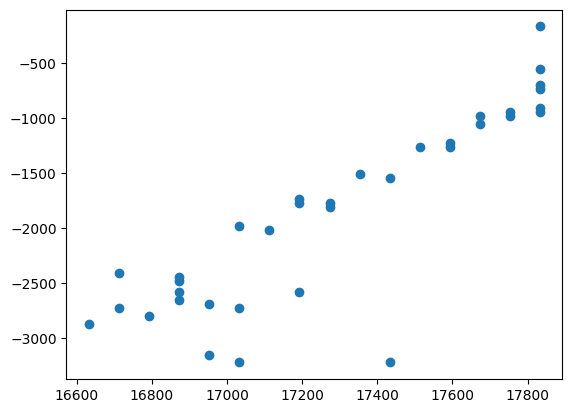

In [8]:
plt.scatter(event_0[:,4], event_0[:,3])

In [9]:
merged_tree = file_python["MergedTree"]
nns = merged_tree['MergedNeutrinoNumber'].array()
detsimPE = merged_tree['MergedDetSimHitPE'].array()
all_hits_array = np.column_stack([nns, detsimPE])
nn_info = []
for nn in np.unique(all_hits_array[:,0]):
    nn_subarray = all_hits_array[all_hits_array[:,0] == nn]
    visible_PE_sum = np.sum(nn_subarray[:,1])
    n_hits = len(nn_subarray[:,1])
    nn_info.append([nn, n_hits,visible_PE_sum])
            
nn_info_array = np.vstack(nn_info)

In [10]:
len(nn_info_array )

2473

In [11]:
nn_info_array[nn_info_array[:,0] == 25]

array([[  25.        ,   35.        , 1188.70240735]])

In [12]:
len(nn_info_array[nn_info_array[:,0] == 2])

0

In [13]:
#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------#
#Imports
import numpy as np
import matplotlib.pyplot as plt
import collections
import ROOT as root
import awkward as ak
import uproot
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KernelDensity
from scipy.signal import find_peaks
import sys
#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------#
#Functions
#(collective_neutrino_number, collective_hit_number, bar_x, bar_y, bar_z, collective_time, total_pe, bar_orientation_code, file_no, truth_spill)
def BuildInputArray(merged_hits_tree_):
    nns = merged_tree['MergedNeutrinoNumber'].array()
    hns = merged_tree['MergedHitNumber'].array()
    trackids = merged_tree['MergedTrackid'].array()
    detsimx = merged_tree['MergedDetSimHitX'].array()
    detsimz = merged_tree['MergedDetSimHitZ'].array()
    detsimt = merged_tree['MergedDetSimHitT'].array()
    detsimPE = merged_tree['MergedDetSimHitPE'].array()
    spill_nos = merged_tree['MergedSpillNumber'].array()
    file_number = merged_tree['MergedFileNumber'].array()
    array = np.column_stack([nns, hns, trackids, detsimx, detsimz, detsimt, detsimPE, file_number, spill_nos])
    sorted_array = array[np.argsort(array[:,5])]
    return(sorted_array)

In [14]:
BuildInputArray(merged_tree)

<Array [[0, 347, 3, ..., 222, 2.5e+03, 0], ...] type='91354 * 9 * float64'>

In [15]:
def MakeKDSegments(hits, bandwidth = 15, mesh_points = 1000, plot = False):
    
    hit_ts = hits[:,5].to_numpy() #extract just the time series data. 
    
    hit_ts_reshaped = hit_ts.reshape(-1, 1)

    # KDE fitting using a gaussian kernel. 
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(hit_ts_reshaped)

    # Evaluate KDE on a fine grid - project our function onto a fine grid to look for local minima
    #This is a necessary step to be able to find our local minima numerically. Basically the kde gives us our functional form, we need to plot it on points to get out the pdf. 
    #The plotting with the points is accomplished by pulling the score_samples method, which returns log likelihoods. We then convert these into actually probabilitiy densities. 
    t_plot = np.linspace(hit_ts.min() - 2, hit_ts.max() + 2, mesh_points).reshape(-1, 1) 
    log_dens = kde.score_samples(t_plot)
    dens = np.exp(log_dens)

    # Find valleys in KDE curve (ie, local minima)
    #Can use scipy peak finding, but invert data so we are really finding the local minima! Returns indices
    inverted = -dens
    valleys, _ = find_peaks(inverted)
    valley_positions = t_plot[valleys].flatten() #this step maps our indices onto actual times. 

    # Assign cluster index based on which region the point falls into
    def assign_cluster(t, boundaries):
        for i, b in enumerate(boundaries): #will loop through boundaries and the last one assigned will be the one it fits into.
            if t < b:
                return(i)
        return(len(boundaries))

    labels = np.array([assign_cluster(t, valley_positions) for t in hit_ts]) #assign labels to our hits. 

    
    if (plot == True): #output a KDE plot
        plt.plot(t_plot[:, 0], dens, label="KDE")
        plt.scatter(hit_ts, np.zeros_like(hit_ts), c=labels, cmap='tab20', s=50, label="Time Segments")
        for v in valley_positions:
            plt.axvline(v, color='gray', linestyle='--', linewidth=1)
        plt.title("KDE-based hit Clustering")
        plt.xlabel("Hit Time")
        plt.yticks([])
        plt.legend()
        plt.show()

    print(f"We found {len(np.unique(labels))} clusters")
    clusters_added = np.column_stack((hits, labels)) #save our data with cluster labels added to the end of each hit row. 
    
    return(clusters_added)

In [16]:
time_sorted_hits = BuildInputArray(merged_tree)

In [17]:
spills_fine_segmented = [] #this list will store all of the hits with fine segmentation grouped by spill. 
spills = np.unique(time_sorted_hits[:,-1]) #grab spill numbers (should always be 0,12 for current sim)
mesh_points_fine = 10000
bandwidth_fine = 15
for spill_no in spills:
    selected_spill = spill_no
    hits_in_spill = time_sorted_hits[time_sorted_hits[:,-1] == selected_spill ] #grabbing our desired spill

    #We can include a routine here to scan and eliminate long-lived neutrons.
    hit_time_range = (max(hits_in_spill[:,5]) - min(hits_in_spill[:,5]))
    if hit_time_range > 1200000000: #set a threshold at hits occuring a full spill step late. 
        rel_time = min(hits_in_spill[:,5]) 
        ceiling_time = rel_time + 1200000000
        indices = np.where([hits_in_spill[:,5] > ceiling_time])[1][0] #grab index of hits greater than ceiling time.
        hits_in_spill = np.delete(hits_in_spill, indices, axis = 0)
        print(f'deleted index {indices} from spill {spill_no}')
        
    time_segmented = MakeKDSegments(hits_in_spill, bandwidth = bandwidth_fine, mesh_points = mesh_points_fine, plot = False)
    spills_fine_segmented.append(time_segmented)

time_segmented_hits = np.vstack(spills_fine_segmented)

We found 145 clusters
We found 128 clusters
We found 131 clusters
We found 120 clusters
We found 131 clusters
We found 133 clusters
We found 154 clusters
We found 125 clusters
We found 135 clusters
We found 150 clusters
We found 141 clusters
We found 137 clusters
We found 126 clusters


In [18]:
#DBSCAN code
def BiasedDBSCAN(seg_hits_, Epsilon, MinCluster, scale_vec): #scale_vec is a tuple like (z_scale, x_scale, t_scale)
    z_scale, x_scale, t_scale = scale_vec
    nns = seg_hits_[:,0]
    hit_xs = seg_hits_[:,2]
    hit_zs = seg_hits_[:,4]
    hit_ts = seg_hits_[:,5]
    if len(np.unique(hit_xs)) > 1 and len(np.unique(hit_zs)) > 1 and len(np.unique(hit_ts)) > 1 : #this serves to check if there is more than 3 unique dimensions in our vector. If none, just assign same label 0 for whole group. 
        min_x = min(hit_xs)
        max_x = max(hit_xs)
        x_range = max_x - min_x
        normalized_xs = (hit_xs + abs(min_x)) / x_range
        scaled_xs = x_scale * normalized_xs

        #Normalize z
        min_z = min(hit_zs)
        max_z = max(hit_zs)
        z_range = max_z - min_z
        normalized_zs = (hit_zs - min_z) / (z_range)
        scaled_zs = z_scale * normalized_zs

        #Normalize t (this won't work for negative t I don't think..)
        min_t = min(hit_ts)
        max_t = max(hit_ts)
        t_range = max_t - min_t
        normalized_ts = (hit_ts - min_t) / (t_range)
        scaled_ts = t_scale * normalized_ts

        scaled_hit_vecs = []
        for i in range(len(scaled_xs)):
            scaled_hit_vec = [scaled_zs[i], scaled_xs[i], scaled_ts[i]]
            scaled_hit_vecs.append(scaled_hit_vec)

        scaled_hit_vec_array = np.array(scaled_hit_vecs)

        labels = (DBSCAN(eps = Epsilon, min_samples = MinCluster).fit(scaled_hit_vec_array)).labels_
    else:
        labels = np.zeros_like(hit_xs)

    
    return(np.column_stack((seg_hits_, labels)))

#This function runs DBSCAN on a full file worth of hit segments. 
def FileRunDBSCAN(hits_segmented_, EPSILON, MINPOINTS, scale_vector):
    spills = np.unique(hits_segmented_[:,-3])
    labeled_segments = []
    for spill_no in spills:
        #the hits in a given spill
        spill_hits = hits_segmented_[(hits_segmented_[:,-3] == spill_no)]
        segments = np.unique(spill_hits[:,-1])
        for segment in segments:
            #the hits in a given segment of a spill
            segment_hits = spill_hits[spill_hits[:,-1] == segment]
            labeled_hits = BiasedDBSCAN(segment_hits, EPSILON, MINPOINTS, scale_vector)
            labeled_segments.append(labeled_hits)

    return(np.vstack(labeled_segments))


In [19]:
dbscanned = np.load('/sdf/home/k/ktwall/hits_clustered_epsilon_0.1_2500.npz')['first']

In [20]:
neutrino_tree.keys()
neutrino_info_set = np.column_stack( (neutrino_tree["VisibleHits"].array(), neutrino_tree["VisiblePEs"].array() ) ).to_numpy()
neutrino_info_set[0]

array([  29.        , 1453.28751381])

In [21]:
def time_segment_eval(dbscanned, neutrino_info_set):
    time_segment_metric_array = np.zeros((len(neutrino_info_set),3))

    for i in range(len(neutrino_info_set)):
        time_segment_metric_array[i][0] = i

    segment_occupancies = []
    for spill_ in (np.unique(dbscanned[:,-3])):
        spill_hits = dbscanned[dbscanned[:,-3] == spill_]
        for segment in np.unique(spill_hits[:,-2]):
            segment_hits = spill_hits[spill_hits[:,-2] == segment]
            segment_occupancies.append(len(np.unique(segment_hits[:,0])))
            for nn in np.unique(segment_hits[:,0]): #grab all the nns in the segment
                nn_hits = segment_hits[segment_hits[:,0] == nn]

                #grab segment splits
                seen_hits = len(nn_hits)
                seen_PEs = np.sum(nn_hits[:,6])

                #grab totals
                nn_vis_hits = neutrino_info_set[int(nn)][0]
                nn_vis_PEs = neutrino_info_set[int(nn)][1]

                #Update containment array
                if (time_segment_metric_array[int(nn)][1]) <= (seen_hits / nn_vis_hits) :
                    time_segment_metric_array[int(nn)][1] = seen_hits / nn_vis_hits #hits contained

                if (time_segment_metric_array[int(nn)][2]) <= (seen_PEs / nn_vis_PEs) :
                    time_segment_metric_array[int(nn)][2] = seen_PEs / nn_vis_PEs #PEs contained

    hit_content_mask = neutrino_info_set[:,0] != 0
    time_segment_metric_array[hit_content_mask]
    return((time_segment_metric_array[hit_content_mask], segment_occupancies))

In [22]:
def dbscan_eval(dbscanned, neutrino_info_set):
    dbscan_metric_array = np.zeros((len(neutrino_info_set),3))

    for i in range((len(neutrino_info_set))):
        dbscan_metric_array[i][0] = i

    dbscan_occupancies = []
    for spill_ in (np.unique(dbscanned[:,-3])):
        spill_hits = dbscanned[dbscanned[:,-3] == spill_]
        for segment in np.unique(spill_hits[:,-2]):
            segment_hits = spill_hits[spill_hits[:,-2] == segment]
            for cluster in np.unique(segment_hits[:,-1]):
                cluster_hits = segment_hits[segment_hits[:,-1] == cluster]
                dbscan_occupancies.append(len(np.unique(cluster_hits[:,0])))
                for nn in np.unique(cluster_hits[:,0]): #grab all the nns in the cluster
                    nn_hits = cluster_hits[cluster_hits[:,0] == nn]

                    #grab segment splits
                    seen_hits = len(nn_hits)
                    seen_PEs = np.sum(nn_hits[:,6])

                    #grab totals
                    nn_vis_hits = neutrino_info_set[int(nn)][0]
                    nn_vis_PEs = neutrino_info_set[int(nn)][1]

                    #Update containment array
                    if (dbscan_metric_array[int(nn)][1]) <= (seen_hits / nn_vis_hits) :
                        dbscan_metric_array[int(nn)][1] = seen_hits / nn_vis_hits #hits contained

                    if (dbscan_metric_array[int(nn)][2]) <= (seen_PEs / nn_vis_PEs) :
                        dbscan_metric_array[int(nn)][2] = seen_PEs / nn_vis_PEs #PEs contained

    hit_content_mask = neutrino_info_set[:,0] != 0
    return((dbscan_metric_array[hit_content_mask], dbscan_occupancies))

In [24]:
plt.hist(dbscan_metric_array[hit_content_mask][:,1])

NameError: name 'dbscan_metric_array' is not defined

In [28]:
test_file = np.load('/sdf/home/k/ktwall/hits_clustered_epsilon_0.1_2500.npz')